<a href="https://colab.research.google.com/github/utsavnandi/Kaggle-SIIM-ISIC-Melanoma-Classification/blob/master/SIIM_ISIC_Melanoma_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## One-time


In [0]:
%%time
!pip uninstall kaggle -y
!pip install kaggle==1.5.6 -q
!pip install -U git+https://github.com/albu/albumentations -q
!pip install -U git+https://github.com/rwightman/pytorch-image-models -q
!pip install neptune-client -q
!mkdir ~/.kaggle/
!cp ./kaggle.json  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shonenkov/melanoma-merged-external-data-512x512-jpeg
!unzip melanoma-merged-external-data-512x512-jpeg.zip -d ./data/
!rm melanoma-merged-external-data-512x512-jpeg.zip
!kaggle competitions download siim-isic-melanoma-classification -f sample_submission.csv
!kaggle competitions download siim-isic-melanoma-classification -f test.csv
!kaggle competitions download siim-isic-melanoma-classification -f train.csv
!unzip train.csv -d ./data/
!mv ./test.csv ./data/
!mv ./sample_submission.csv ./data/
!rm train.csv.zip
!mkdir ./logs/

In [0]:
# kaggle datasets download tunguz/siimisic-melanoma-resized-images -f x_train_224.npy
# kaggle datasets download tunguz/siimisic-melanoma-resized-images -f x_test_224.npy
# unzip ./680899%2F1200702%2Fcompressed%2Fx_train_224.npy.zip -d ./data/
# unzip ./680899%2F1200702%2Fcompressed%2Fx_test_224.npy.zip -d ./data/
# rm ./680899%2F1200702%2Fcompressed%2Fx_train_224.npy.zip
# rm ./680899%2F1200702%2Fcompressed%2Fx_test_224.npy.zip

## Setup

In [0]:
import os
import gc
import time
import datetime
import random
from getpass import getpass
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import auth
from google.cloud import storage

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import GradScaler
import torchvision

import timm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import neptune

def seed_everything(seed):
    random.seed(seed)
    #np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(43)

!nvidia-smi

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Sun Jun  7 12:47:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
PROJECT_ID = getpass(prompt='Enter gcp project id: ')
bucket_name = getpass(prompt='Enter gcp bucket name: ')

if PROJECT_ID != '' and bucket_name !='':
    auth.authenticate_user()

!gcloud config set project {PROJECT_ID}

if PROJECT_ID != '' and bucket_name !='':
    storage_client = storage.Client(project=PROJECT_ID)

def upload_blob(source_file_name, destination_blob_name, bucket_name=bucket_name, PROJECT_ID=PROJECT_ID):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

Enter gcp project id: ··········
Enter gcp bucket name: ··········
Updated property [core/project].


In [0]:
NEPTUNE_API_TOKEN = getpass(prompt='Enter neptune api token: ')

if NEPTUNE_API_TOKEN != '':
    os.environ['NEPTUNE_API_TOKEN'] = NEPTUNE_API_TOKEN
    log = True
    

Enter neptune api token: ··········


In [0]:
DATA_DIR = '/content/data/'

In [0]:
df_train = pd.read_csv(DATA_DIR+'folds.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv').rename(columns={'image_name':'image_id'})
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [0]:
df_train['fold'].value_counts()

0    12219
1    12106
2    12072
4    12048
3    12042
Name: fold, dtype: int64

In [0]:
fold_no = 1
X_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col != 'target']]
y_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col == 'target']]
X_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col != 'target']]
y_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col == 'target']]

In [0]:
# %%time
# df_train = pd.read_csv(DATA_DIR+'train.csv')
# df_test = pd.read_csv(DATA_DIR+'test.csv')
# sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
# train_images = np.load(DATA_DIR+'x_train_224.npy') #x_train_128
# train_labels = df_train['target']
# test_images = np.load(DATA_DIR+'x_test_224.npy') #x_test_128

In [0]:
# X_train, X_val, y_train, y_val = train_test_split(
#     train_images, train_labels.values, 
#     test_size=0.3, random_state=43,
#     stratify=train_labels,
# )
# del train_images, train_labels
# gc.collect()
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (48381, 8)
y_train (48381, 1)
X_val (12106, 8)
y_val (12106, 1)


In [0]:
print('Train target distribution: ')
#print(pd.Series(y_train).value_counts())
print(y_train['target'].value_counts())
print('Val target distribution: ')
#print(pd.Series(y_val).value_counts())
print(y_val['target'].value_counts())

Train target distribution: 
0    43997
1     4384
Name: target, dtype: int64
Val target distribution: 
0    11011
1     1095
Name: target, dtype: int64


## Dataset

In [0]:
# class MelanomaDataset(Dataset):
#     def __init__(self, img_arr, labels, isEval=False, transform=None):
#         super().__init__()
#         self.images = img_arr
#         self.transform = transform
#         self.isEval = isEval
#         if not self.isEval:
#             self.labels = labels

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         if torch.is_tensor(index):
#             index = index.tolist()

#         image = self.images[index].astype(np.uint8)

#         if self.transform is not None:
#             res = self.transform(image=image)
#             image = res['image']
#         else:
#             image = np.transpose(image, (2, 1, 0))

#         if self.isEval:
#             return image
#         target = self.labels[index].astype(np.float32)
#         return image, target


## Alt Dataset

In [0]:
class MelanomaDataset(Dataset):
    def __init__(self, df, labels, isEval=True, transform=None):
        super().__init__()
        self.image_id = df['image_id'].values
        self.transform = transform
        self.isEval = isEval
        if not self.isEval:
            self.labels = labels.values

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        if self.isEval:
            image_name = DATA_DIR + f'512x512-test/512x512-test/{self.image_id[index]}.jpg'
        else:
            image_name = DATA_DIR + f'512x512-dataset-melanoma/512x512-dataset-melanoma/{self.image_id[index]}.jpg'

        image = cv2.imread(image_name, cv2.IMREAD_COLOR).astype(np.uint8)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = np.transpose(image, (2, 1, 0))

        if self.isEval:
            return image
        target = self.labels[index].astype(np.float32)
        return image, target
        

## Augmentations

In [0]:
#%%writefile augmentations.txt
# Transforms
# B0 - 224
# B1 - 240
# B2 - 260
# B3 - 300
# B4 - 380

IMG_SIZE = 260
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def strong_aug(p=1.0):
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=2, always_apply=True, p=1),
        A.RandomResizedCrop(
            IMG_SIZE, IMG_SIZE, scale=(0.8, 1.0), interpolation=2, p=0.3
        ),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.3
        ),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.5),
        A.HueSaturationValue(p=0.3),
        A.MultiplicativeNoise(multiplier=[0.7, 1.3], elementwise=True, p=0.5),
        #A.OneOf([
        #    A.RandomGridShuffle(grid=(3, 3), p=0.5),
        #    A.Cutout(num_holes=1, max_h_size=96, max_w_size=96, p=0.5),     
        #], p=1.0),
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0),
    ], p=p)

def get_valid_transform():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=2, always_apply=True, p=1),
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0),
    ])
    

In [0]:
def rand_bbox(size, lam, device='cuda:0'):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    #cut_rat = torch.sqrt(1 - lam).to(device)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
    #cut_w = (W * cut_rat).int().to(device)
    #cut_h = (H * cut_rat).int().to(device)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    #cx = torch.LongTensor(1).random_(0, W).to(device)
    #cy = torch.LongTensor(1).random_(0, H).to(device)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    #bbx1 = torch.clamp(cx - cut_w // 2, 0, W).to(device)
    #bby1 = torch.clamp(cy - cut_h // 2, 0, H).to(device)
    #bbx2 = torch.clamp(cx + cut_w // 2, 0, W).to(device)
    #bby2 = torch.clamp(cy + cut_h // 2, 0, H).to(device)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets1, alpha=1):
    indices = np.random.permutation(data.size(0))
    #indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    
    lam = np.random.beta(alpha, alpha)
    #lam = torch.distributions.beta.Beta(alpha, alpha).sample().to('cuda:0')
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)

    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = [targets1, shuffled_targets1, lam]
    return data, targets

def mixup(data, targets1, alpha=1):
    indices = np.random.permutation(data.size(0))
    #indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    lam = np.random.beta(alpha, alpha)
    #lam = torch.distributions.beta.Beta(alpha, alpha).sample().to('cuda:0')
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, lam]

    return data, targets
    

## Visualise Transforms

In [0]:
def visualize_dataset(dataset, shuffle=True):
    labels_vcount = y_train['target'].value_counts()
    #labels_vcount = pd.Series(y_train).value_counts()
    class_counts = [labels_vcount[0].astype(np.float32), labels_vcount[1].astype(np.float32)]
    num_samples = sum(class_counts)
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[y_train['target'].values[i]] for i in range(int(num_samples))]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

    dl = DataLoader(dt, batch_size=32, sampler=sampler)
    for images, targets in dl:
        images = images.to('cuda:0')
        targets = targets.to('cuda:0')
        if np.random.rand()<0.5:
            images, targets = cutmix(images, targets)
        else:
            images, targets = mixup(images, targets)
        for i, (image, target, shuffled_target) in enumerate(zip(images, targets[0], targets[1])):
            print(image.shape)
            image = image.detach().cpu().numpy().transpose((1,2,0))
            plt.imshow(image.astype(np.uint8))
            plt.show()
            print('actual target', target)
            print('shuffled target', shuffled_target)
            print('---------------------------------')
            if i>9:
                break
        break

#dt = MelanomaDataset(X_train[:32], y_train[:32], isEval=False, transform=strong_aug())
#dt = MelanomaDataset(X_train, y_train, isEval=False, transform=strong_aug())
#visualize_dataset(dt, False)

## RoC plot

In [0]:
def plot_roc(y_true, y_pred, show=False):
    testy, lr_probs = y_true, y_pred
    ns_probs = [0 for _ in range(len(testy))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs) #lr_probs: predictions
    # plot the roc curve for the model
    plt.figure(figsize=(8,8))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    #save
    filename = f'/content/logs/roc_curve_{datetime.datetime.now().strftime("%d-%m-%Y-%HH-%MM")}.png'
    plt.savefig(filename)
    # show the plot
    if show:
        plt.show()
    else:
        plt.clf()
    return filename


## Model

In [0]:
class ResNet50Mod(nn.Module): 

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)
    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b0(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b0', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b0_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b0', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b1(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b1', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b2_ns(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b2_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b1_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b1', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b3(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b3_ns(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b3_ns_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b3_ns_Mod_v2(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, in_features)
        self.relu_1 = nn.ReLU()
        self.bn_1 = nn.BatchNorm1d(in_features)
        self.fc_1 = nn.Linear(in_features, int(in_features/2))
        self.bn_2 = nn.BatchNorm1d(int(in_features/2))
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.relu_1(x)
        x = self.bn_1(x)
        x = self.fc_1(x)
        x = self.bn_2(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b4_ns(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class swsl_resnext101_32x4d(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('swsl_resnext101_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class swsl_resnext101_32x4d_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('swsl_resnext101_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b5(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b5', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b5_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b5', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b5_ns_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

#Encoder
#--Neck--
#BatchNorm
#Linear
#---
#Relu
#BatchNorm
#Linear
#BatchNorm
#--Head--
#Linear heads

## Custom Losses

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def ohem_loss(cls_pred, cls_target, rate):
    ohem_cls_loss = F.binary_cross_entropy_with_logits(cls_pred, cls_target, reduction='none')
    batch_size = cls_pred.size(0)
    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate))
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss

def cutmix_mixup_criterion(preds1, targets, rate=0.7, epsilon=0.05):
    targets1, targets2, lam = targets[0], targets[1], targets[2]
    #loss = lam * smooth_ohem_criterion(preds1, targets1, rate, epsilon) + (1 - lam) * smooth_ohem_criterion(preds1, targets2, rate, epsilon)
    loss = lam * smooth_criterion(preds1, targets1, epsilon) + (1 - lam) * smooth_criterion(preds1, targets2, epsilon)
    return loss


def smooth_ohem_criterion(y_pred, y_true, rate, e):
    e = torch.tensor(e).to(device)
    y_true = torch.where(y_true == 0, e, y_true)
    y_true = torch.where(y_true == 1, (1-e), y_true)
    return ohem_loss(y_pred, y_true, rate)

def smooth_criterion(y_pred, y_true, e=0.05):
    e = torch.tensor(e).to(device)
    y_true = torch.where(y_true == 0, e, y_true)
    y_true = torch.where(y_true == 1, (1-e), y_true)
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

def criterion(y_pred, y_true):
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

def focal_criterion(y_pred, y_true):
    return FocalLoss()(y_pred, y_true)

def rank_loss(y_pred, y_true):
    margin = 0.5
    #pos = torch.where(y_pred>margin, 1, 0)
    #neg = torch.where(y_pred<margin, 1, 0)
    return -F.logsigmoid(y_pred - y_true).mean()

## Train script

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_datasets(X_train, y_train, X_val, y_val):
    datasets = {}
    datasets['train'] = MelanomaDataset(
        X_train, y_train, isEval=False, transform=strong_aug()
    ) #strong_aug get_train_transform
    datasets['valid'] = MelanomaDataset(
        X_val, y_val, isEval=False, transform=get_valid_transform()
    )
    return datasets

def train_one_epoch(loader, model, optimizer, epoch, scheduler=None, scaler=None, log=True):
    model.train()
    running_loss = 0.0
    for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)): #
        images = images.to(device)
        targets = targets.to(device)#.unsqueeze(1)
        
        optimizer.zero_grad()

        y_pred = model(images.float())
        loss = rank_loss(y_pred, targets)
        #if np.random.rand()<0.33:
        #    if np.random.rand()<0.5:
        #        images, targets = cutmix(images, targets)
        #    else:
        #         images, targets = mixup(images, targets)
        #    y_pred = model(images.float())
        #    #if epoch<9:
        #    loss = cutmix_mixup_criterion(y_pred, targets, None, 0.05)
        #    #else:
        #    #    loss = cutmix_mixup_criterion(y_pred, targets, 0.9, 0.)
        #else:
        #    y_pred = model(images.float())
        #    #if epoch<9:
        #    #loss = smooth_ohem_criterion(y_pred, targets, 1.0, 0.)   
        #    loss = smooth_criterion(y_pred, targets, 0.05)
        #    #else:
        #    #    loss = smooth_ohem_criterion(y_pred, targets, 0.9, 0.)

        running_loss += float(loss)
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        if log:
            neptune.log_metric("Loss/train", float(loss))

    return running_loss/len(loader)

def val_one_epoch(loader, model):
    model.eval()
    running_loss = 0.0
    y_preds_list = []
    targets_list = []
    with torch.no_grad():
        for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
            images = images.to(device)
            targets = targets.to(device)#.unsqueeze(1)
            
            y_pred = model(images.float())
            loss = criterion(y_pred, targets)
            
            running_loss += float(loss)
            y_preds_list.append(torch.sigmoid(y_pred).cpu().numpy())
            targets_list.append(targets.cpu().numpy())
        y_true = np.vstack(targets_list)
        y_pred = np.vstack(y_preds_list)
        auc_score = roc_auc_score(y_true, y_pred)
        #auc_score = fast_auc(y_true, y_pred)
        roc_plot = plot_roc(y_true, y_pred)
        print(f'roc_auc_score: {auc_score}')
        print(f'average loss for val epoch: {running_loss/len(loader)}')
    return running_loss/len(loader), auc_score, roc_plot
   
def save_upload(model, optimizer, best_score, epoch, fold=None, exp_name='model'):
    if fold:
        NAME = 'siim-isic_'+exp_name+f'_fold_{str(fold+1)}_{str(epoch+1)}.ckpt'
    NAME = 'siim-isic_'+exp_name+f'_{str(epoch+1)}.ckpt'
    MODEL_PATH = NAME
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, MODEL_PATH)
    print(f"Saved ckpt for epoch {epoch+1}, new best score: {best_score}")
    upload_blob(MODEL_PATH, NAME)
    print(f"Uploaded ckpt for epoch {epoch+1}")


In [0]:
FLAGS = {}
FLAGS['batch_size'] = 32
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 3e-4
FLAGS['num_epochs'] = 20
FLAGS['weight_decay'] = 5e-4
FLAGS['momentum'] = 0.9
FLAGS['log_interval'] = 175
FLAGS['img_size'] = IMG_SIZE
FLAGS['loss'] = 'BCE unbalanced hard label ohem'
FLAGS['optimizer'] = 'AdamW'
FLAGS['exp_name'] = 'Tf_efficientnet_b2_ns'
FLAGS['fold'] = 'N/A'
exp_description = '''
Tf_efficientnet_b2_ns with base head,
Extra Data + Color fix
hard label ohem 
cutmix + mixup
RandomWeightedSampler,
RandomGridShuffle + more strong_aug p=1.0,
imsize 260
'''
def fit(X_train, y_train, X_val, y_val, fold=None, log=True):
    exp_name = FLAGS['exp_name']
    best_score = 0.0

    #model = Tf_efficientnet_b1_Mod().to(device)
    model = Tf_efficientnet_b2_ns().to(device)
    #model = Tf_efficientnet_b3_ns().to(device)
    #model = swsl_resnext101_32x4d().to(device)
    #model = gluon_seresnext50_32x4d().to(device)
    if log:
        neptune.init('utsav/SIIM-ISIC', api_token=NEPTUNE_API_TOKEN)
        neptune.create_experiment(
            exp_name, exp_description, params=FLAGS,
            upload_source_files='*.txt'
        )
    
    #optimizer = torch.optim.SGD(
    #    model.parameters(), lr=FLAGS['learning_rate'], 
    #    momentum=FLAGS['momentum'], 
    #    weight_decay=FLAGS['weight_decay']
    #)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=FLAGS['learning_rate'], 
        weight_decay=FLAGS['weight_decay']
    )

    # scheduler = ...
    # todo ...
    
    datasets = get_datasets(X_train, y_train, X_val, y_val)
    
    #sampler
    #labels_vcount = pd.Series(y_train).value_counts()
    labels_vcount = y_train['target'].value_counts()
    class_counts = [labels_vcount[0].astype(np.float32), labels_vcount[1].astype(np.float32)]
    num_samples = sum(class_counts)
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[y_train['target'].values[i]] for i in range(int(num_samples))]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    #loaders
    train_loader = DataLoader(
        datasets['train'], batch_size=FLAGS['batch_size'], 
        num_workers=FLAGS['num_workers'],
        sampler=sampler,
        pin_memory=True,
    )
    val_loader = DataLoader(
        datasets['valid'], batch_size=32, shuffle=False, 
        num_workers=FLAGS['num_workers'], drop_last=True
    )

    scaler = GradScaler()
    #train loop
    for epoch in range(0, FLAGS['num_epochs']):

        print('-'*27 + f'Epoch #{epoch+1} started' + '-'*27)
        
        train_loss = train_one_epoch(
            train_loader, 
            model, optimizer, 
            epoch, scheduler=None, 
            scaler=scaler, log=log
        )
        
        print()
        print(f'Average loss for epoch #{epoch+1} : {train_loss}')
        val_loss, auc_score, roc_plot = val_one_epoch(val_loader, model)
        
        #logs
        if log:
            neptune.log_metric('AUC/val', auc_score)
            neptune.log_image('ROC/val', roc_plot)
            neptune.log_metric('Loss/val', val_loss)

        #checkpoint+upload
        if (auc_score > best_score) or (best_score-auc_score<0.02):
            if auc_score > best_score:
                best_score = auc_score
            save_upload(
                model, optimizer, 
                best_score, epoch,
                fold, exp_name=exp_name
            )
            
        print('-'*28 + f'Epoch #{epoch+1} ended' + '-'*28)
    if log:
        neptune.stop()
    return model


## Train

In [0]:
# 5 fold CV
# for fold in range(5):
#     print('='*27 + f'Fold #{fold+1} started' + '='*27)
#     X_train = df_train[df_train['fold'] != fold][[col for col in df_train.columns if col != 'target']]
#     y_train = df_train[df_train['fold'] != fold][[col for col in df_train.columns if col == 'target']]
#     X_val = df_train[df_train['fold'] == fold][[col for col in df_train.columns if col != 'target']]
#     y_val = df_train[df_train['fold'] == fold][[col for col in df_train.columns if col == 'target']]
#     FLAGS['fold'] = str(fold+1) 
#     
#     trained_model = train_job(X_train, y_train, X_val, y_val, log=log)
# 
#     print('='*27 + f'Fold #{fold+1} ended' + '='*27)
#neptune.stop()

In [0]:
log = True
try:
    trained_model = fit(X_train, y_train, X_val, y_val, log=log)
except Exception as e:
    if log:
        neptune.stop()
    print(e)
except KeyboardInterrupt:
    if log:
       neptune.stop()

## Inference

In [0]:
#trained_model = ResNet34Mod()
def run_test(model, test_images, ckpts):
    agg_predictions = []
    for ckpt in ckpts:
        model.load_state_dict(torch.load(ckpt)['model_state_dict'])
        model.to(device).eval()
        test_dataset = MelanomaDataset(test_images, labels=None, isEval=True, transform=get_valid_transform())
        test_data_loader = DataLoader(
            test_dataset, batch_size=256, shuffle=False, 
            num_workers=4, pin_memory=True
        )
        predictions = []
        with torch.no_grad():
            for images in tqdm(test_data_loader, total=len(test_data_loader)):
                images = images.to(device)
                y_pred = torch.sigmoid(model(images.float()))
                predictions.append(y_pred.cpu().numpy())
        predictions = np.vstack(predictions)
        plt.hist(predictions.T[0],bins=100)
        plt.ylim((0,500))
        plt.show()
        agg_predictions.append(predictions)
    #can be vectorized
    #avg_predictions = agg_predictions[0]
    #avg_predictions = 0
    avg_predictions = 0
    for predictions in agg_predictions:
        #avg_predictions = np.multiply(avg_predictions, predictions).astype(np.float64)
        avg_predictions = np.add(avg_predictions, predictions).astype(np.float64)
    #avg_predictions = np.power(avg_predictions, (1/float(len(agg_predictions))))
    avg_predictions = np.divide(avg_predictions, float(len(agg_predictions)))
    print('average:')
    plt.hist(avg_predictions.T[0],bins=100)
    plt.ylim((0,500))
    plt.show()
    return avg_predictions

100%|██████████| 43/43 [00:38<00:00,  1.11it/s]


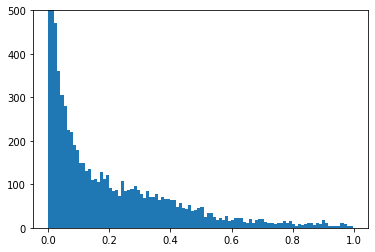

100%|██████████| 43/43 [00:37<00:00,  1.14it/s]


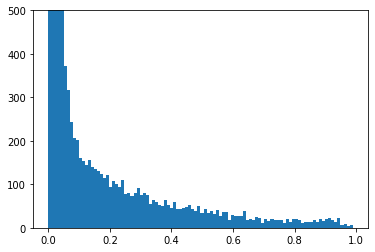

100%|██████████| 43/43 [00:37<00:00,  1.15it/s]


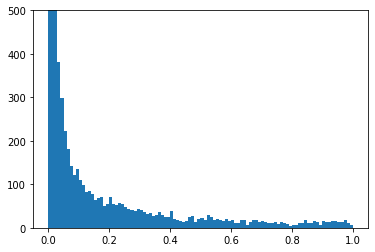

100%|██████████| 43/43 [00:36<00:00,  1.16it/s]


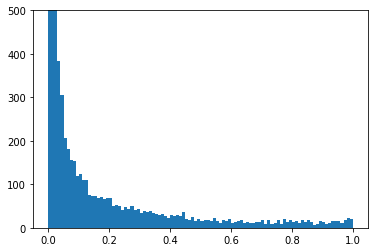

average:


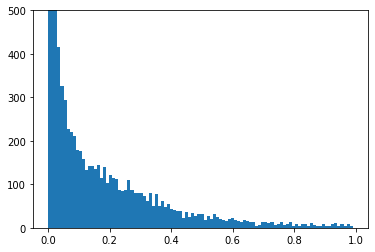

In [0]:
ckpts = [
         '/content/siim-isic_Tf_efficientnet_b2_ns_3.ckpt',
         '/content/siim-isic_Tf_efficientnet_b2_ns_4.ckpt',
         '/content/siim-isic_Tf_efficientnet_b2_ns_6.ckpt',
         '/content/siim-isic_Tf_efficientnet_b2_ns_9.ckpt',
        ]
trained_model = Tf_efficientnet_b2_ns().to(device)
#avg_predictions = run_test(trained_model, test_images, ckpts)
avg_predictions = run_test(trained_model, df_test, ckpts)

In [0]:
pd.Series(avg_predictions.T[0]).describe()

count    10982.000000
mean         0.125315
std          0.178972
min          0.000518
25%          0.008933
50%          0.037047
75%          0.181104
max          0.989767
dtype: float64

In [0]:
pd.Series(np.where(avg_predictions>0.5,1,0).T[0]).value_counts()

0    10496
1      486
dtype: int64

In [0]:
sample_submission.target = avg_predictions.T[0].T

In [0]:
sample_submission.to_csv('submission.csv', index=False)

In [0]:
pd.read_csv('submission.csv')

,image_name,target
0,ISIC_0052060,0.008950
1,ISIC_0052349,0.014407
2,ISIC_0058510,0.002553
3,ISIC_0073313,0.002736
4,ISIC_0073502,0.041002
...,...,...
10977,ISIC_9992485,0.019260
10978,ISIC_9996992,0.023127
10979,ISIC_9997917,0.038641
10980,ISIC_9998234,0.031444


## Submit to Kaggle

In [0]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m {'Exp_89_EffNetB2_3,4,6,9_geo-mean'}

100% 359k/359k [00:05<00:00, 62.6kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [0]:
!kaggle competitions submissions siim-isic-melanoma-classification

fileName        date                 description                                                      status    publicScore  privateScore  
--------------  -------------------  ---------------------------------------------------------------  --------  -----------  ------------  
submission.csv  2020-06-07 14:02:32  Exp_89_EffNetB2_3,4,6,9_geo-mean                                 complete  0.880        None          
submission.csv  2020-06-07 12:55:53  Exp_89_EffNetB2_3,4,6,9_avg                                      complete  0.883        None          
submission.csv  2020-06-07 12:51:01  Exp_89_EffNetB2_19                                               complete  0.865        None          
submission.csv  2020-06-07 05:44:25  Tf_efficientnet_b2_ns_extradat_regularized_ckpt_5_6_9_avg        complete  0.904        None          
submission.csv  2020-06-07 05:32:45  Tf_efficientnet_b2_ns_extradat_regularized_ckpt_2_3_4_5_6_9_avg  complete  0.907        None          
submission.csv  2020